In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd

In [4]:
%%bigquery df
select 
    mmxRequestUUID, clicked, purchased, 
    dist_click_top, dist_purchase_top, 
    dist_click_level2, dist_purchase_level2,
    page_no, query_bin, buyer_segment
from `etsy-sr-etl-prod.yzhang.query_taxo_distrib_match_2023_09_24_summary`

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9598446/9598446 [00:25<00:00, 380972.76rows/s]


In [5]:
df.head()

,mmxRequestUUID,clicked,purchased,dist_click_top,dist_purchase_top,dist_click_level2,dist_purchase_level2,page_no,query_bin,buyer_segment
0,33fd2f8d-1d15-4506-96e6-4d71582e713d,0,0,0.000000,NaN,1.666667,NaN,1,None,Signed Out
1,649dfcbe-9d9c-441a-941f-930a9de9aaa1,0,0,0.291667,NaN,0.291667,NaN,3,None,Habitual
2,e560592b-9c05-403b-a9f5-f63cd83f390c,0,0,1.000000,NaN,0.880763,NaN,2,None,Signed Out
3,1ea6b897-763b-48fd-be71-15d5a001357d,0,0,0.638889,NaN,1.182018,NaN,2,None,Active
4,ea42d577-e83e-4b64-bc62-70c16e26dfeb,0,0,1.352941,1.352941,1.941176,1.764706,1,None,Signed Out


In [7]:
sorted(df.purchased.unique())

[0, 1, 2, 3, 4, 5, 6]

# Do pages with more purchases have closer (smaller) distances between listing and query distribution?

<Axes: xlabel='purchased', ylabel='dist_purchase_top'>

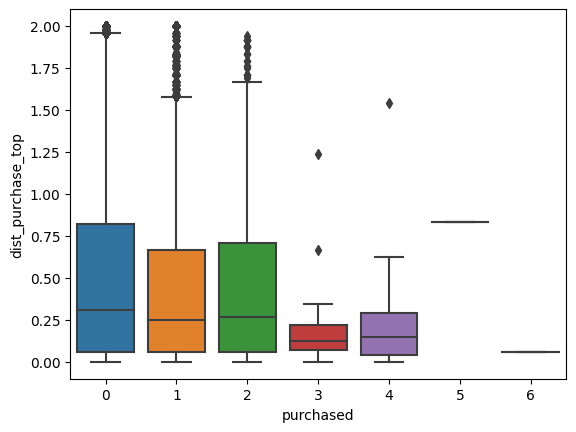

In [8]:
sns.boxplot(
    x=df.purchased, y=df.dist_purchase_top, 
    order=sorted(df.purchased.unique())
)

<Axes: xlabel='purchased', ylabel='dist_purchase_level2'>

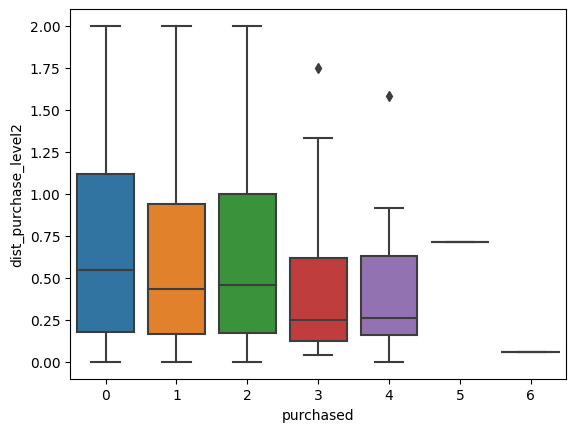

In [9]:
sns.boxplot(
    x=df.purchased, y=df.dist_purchase_level2, 
    order=sorted(df.purchased.unique())
)

<Axes: xlabel='clicked', ylabel='dist_click_top'>

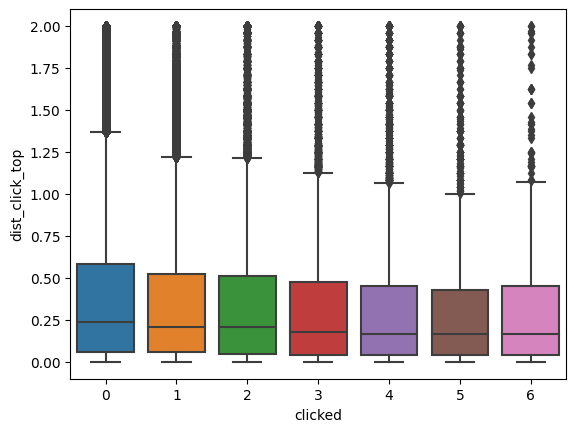

In [10]:
sns.boxplot(
    x=df.clicked, y=df.dist_click_top, 
    order=sorted(df.purchased.unique())
)

<Axes: xlabel='clicked', ylabel='dist_click_level2'>

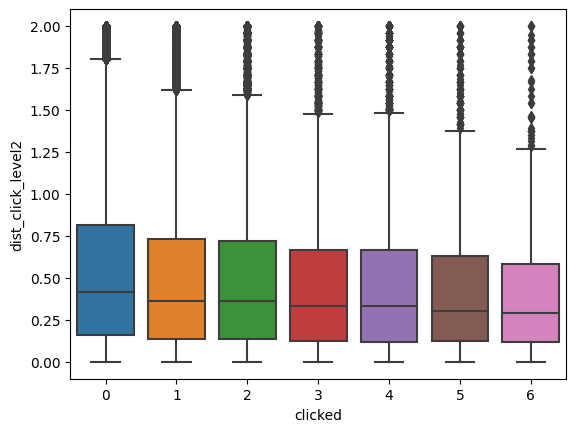

In [11]:
sns.boxplot(
    x=df.clicked, y=df.dist_click_level2, 
    order=sorted(df.purchased.unique())
)

In [13]:
df["has_purchase"] = df.purchased > 0

In [15]:
df.has_purchase.value_counts()

False    9554158
True       44288
Name: has_purchase, dtype: int64

<Axes: xlabel='has_purchase', ylabel='dist_purchase_top'>

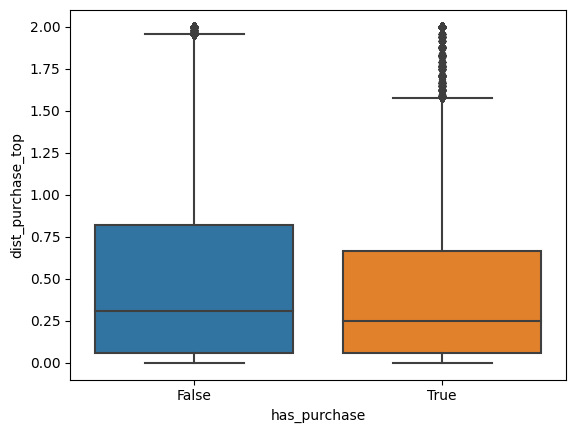

In [16]:
sns.boxplot(x=df.has_purchase, y=df.dist_purchase_top)

<Axes: xlabel='has_purchase', ylabel='dist_purchase_level2'>

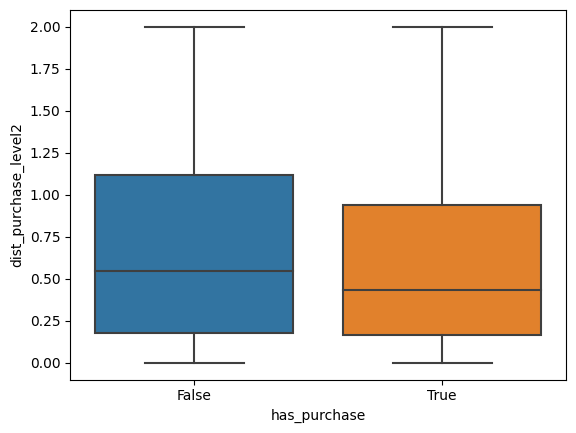

In [17]:
sns.boxplot(x=df.has_purchase, y=df.dist_purchase_level2)

In [19]:
df_sub = df[~df.dist_purchase_top.isna()]
print(df_sub.shape)
print(df_sub.has_purchase.value_counts())

(6797883, 11)
False    6761911
True       35972
Name: has_purchase, dtype: int64


In [21]:
scipy.stats.ttest_ind(
    a=df_sub[df_sub.has_purchase].dist_purchase_top.values,
    b=df_sub[~df_sub.has_purchase].dist_purchase_top.values,
    equal_var=False, alternative='less'
) 

Ttest_indResult(statistic=-28.835714427536587, pvalue=4.1315702599375747e-181)

In [22]:
df_sub = df[~df.dist_purchase_level2.isna()]
print(df_sub.shape)
print(df_sub.has_purchase.value_counts())

(6797883, 11)
False    6761911
True       35972
Name: has_purchase, dtype: int64


In [23]:
scipy.stats.ttest_ind(
    a=df_sub[df_sub.has_purchase].dist_purchase_level2.values,
    b=df_sub[~df_sub.has_purchase].dist_purchase_level2.values,
    equal_var=False, alternative='less'
) 

Ttest_indResult(statistic=-33.96641729074357, pvalue=2.718286203035766e-249)

# By page number

In [25]:
df["page_number"] = df.page_no.apply(lambda x: str(x) if x <= 3 else ">=4")
df.page_number.value_counts()

1      4990242
>=4    2327102
2      1581481
3       699621
Name: page_number, dtype: int64

In [26]:
df_page1 = df[df.page_number == "1"]
df_page2 = df[df.page_number == "2"]
df_page3 = df[df.page_number == "3"]
df_page4plus = df[df.page_number == ">=4"]

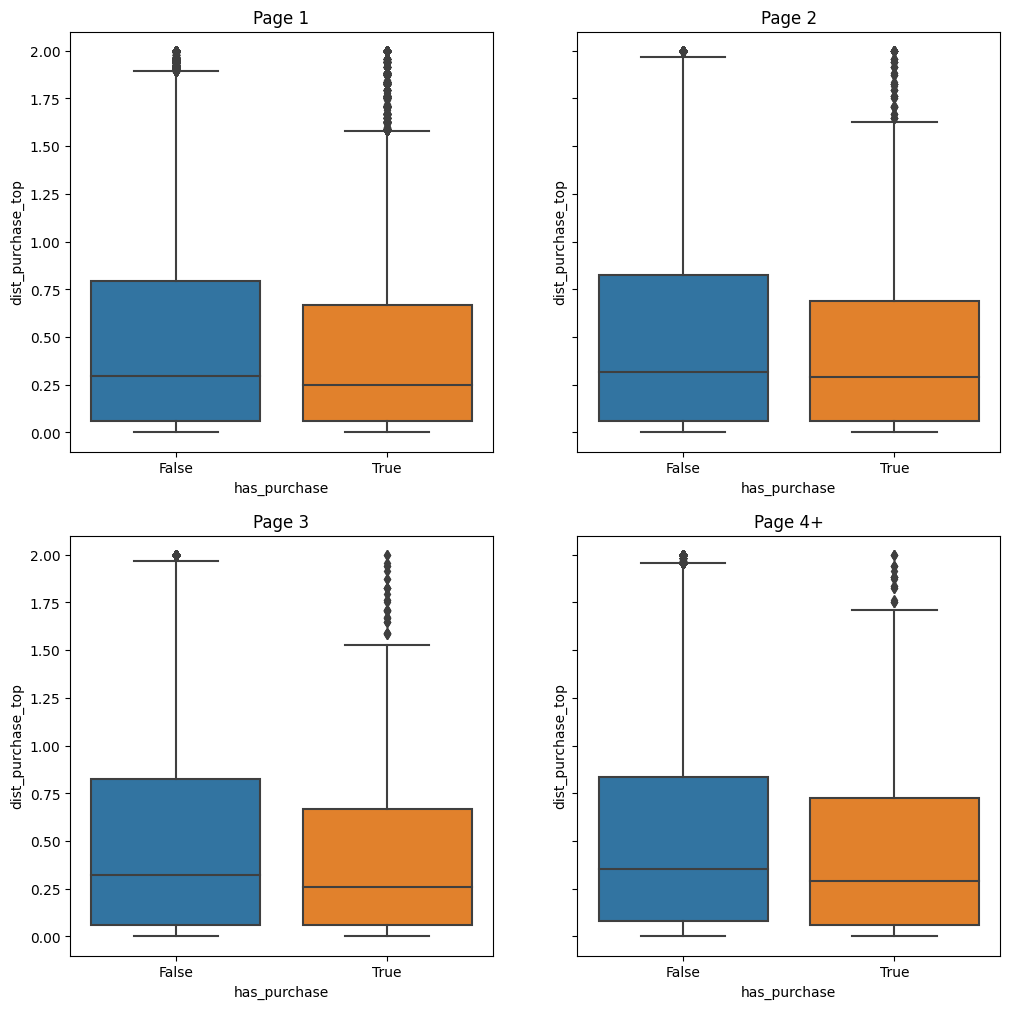

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

sns.boxplot(x=df_page1.has_purchase, y=df_page1.dist_purchase_top, ax=axes[0, 0])
axes[0, 0].set_title("Page 1")

sns.boxplot(x=df_page2.has_purchase, y=df_page2.dist_purchase_top, ax=axes[0, 1])
axes[0, 1].set_title("Page 2")

sns.boxplot(x=df_page3.has_purchase, y=df_page3.dist_purchase_top, ax=axes[1, 0])
axes[1, 0].set_title("Page 3")

sns.boxplot(x=df_page4plus.has_purchase, y=df_page4plus.dist_purchase_top, ax=axes[1, 1])
axes[1, 1].set_title("Page 4+")

plt.show()

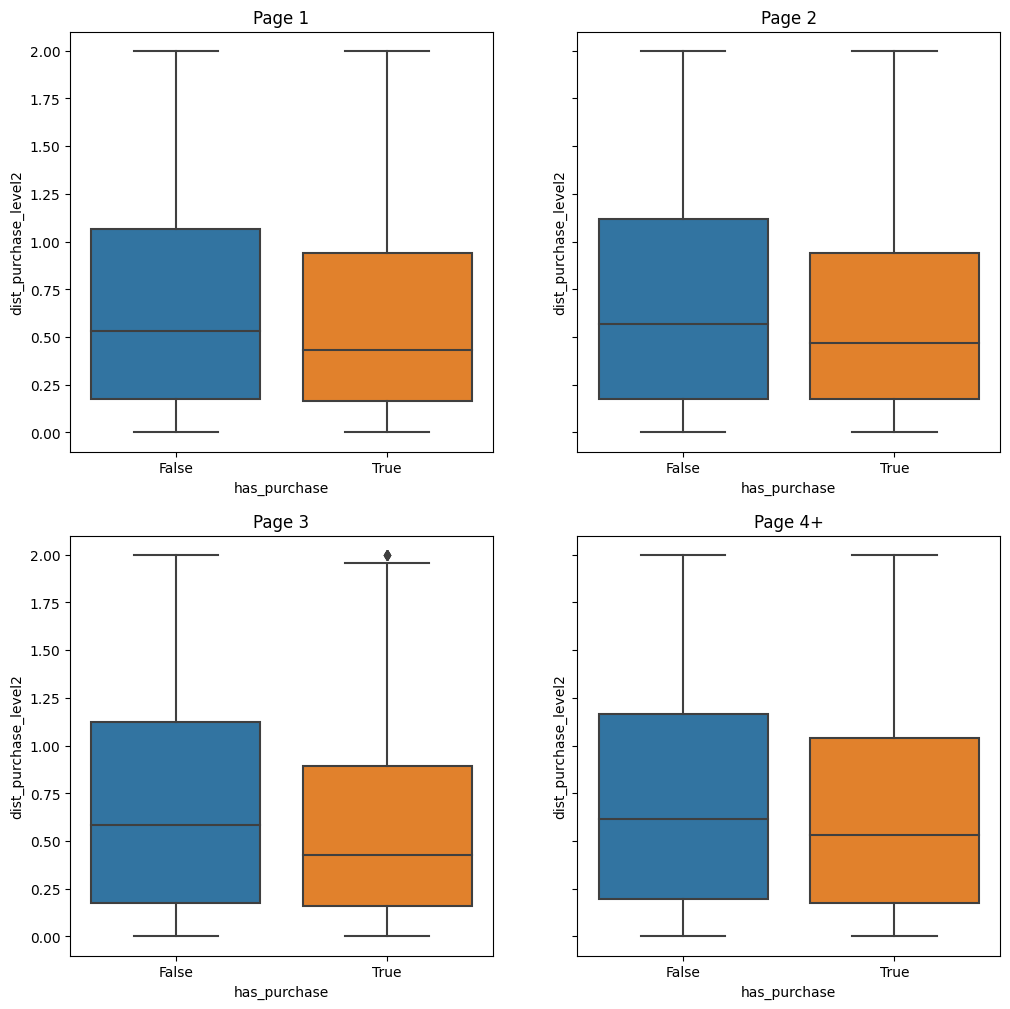

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

sns.boxplot(x=df_page1.has_purchase, y=df_page1.dist_purchase_level2, ax=axes[0, 0])
axes[0, 0].set_title("Page 1")

sns.boxplot(x=df_page2.has_purchase, y=df_page2.dist_purchase_level2, ax=axes[0, 1])
axes[0, 1].set_title("Page 2")

sns.boxplot(x=df_page3.has_purchase, y=df_page3.dist_purchase_level2, ax=axes[1, 0])
axes[1, 0].set_title("Page 3")

sns.boxplot(x=df_page4plus.has_purchase, y=df_page4plus.dist_purchase_level2, ax=axes[1, 1])
axes[1, 1].set_title("Page 4+")

plt.show()

In [32]:
pd.crosstab(df.has_purchase, df.page_number, normalize='columns')

page_number,1,2,3,>=4
has_purchase,,,,
False,0.991941,0.998575,0.998852,0.999564
True,0.008059,0.001425,0.001148,0.000436


In [34]:
df_sub = df_page1[~df_page1.dist_purchase_level2.isna()]
scipy.stats.ttest_ind(
    a=df_sub[df_sub.has_purchase].dist_purchase_level2.values,
    b=df_sub[~df_sub.has_purchase].dist_purchase_level2.values,
    equal_var=False, alternative='less'
) 

Ttest_indResult(statistic=-25.83006763715217, pvalue=5.52509221261028e-146)

# By buyer segment

In [35]:
df_buyer = df[~df.buyer_segment.isna()]
print(df_buyer.shape)
print(df_buyer.has_purchase.value_counts())
print(df_buyer.buyer_segment.value_counts())

(9598446, 12)
False    9554158
True       44288
Name: has_purchase, dtype: int64
Signed Out        5904498
Repeat            1327713
Habitual          1149681
Not Active         615451
Active             436354
High Potential     164749
Name: buyer_segment, dtype: int64


In [36]:
df_signout = df[df.buyer_segment == "Signed Out"]
df_repeat = df[df.buyer_segment == "Repeat"]
df_habitual = df[df.buyer_segment == "Habitual"]
df_na = df[df.buyer_segment == "Not Active"]
df_a = df[df.buyer_segment == "Active"]
df_highp = df[df.buyer_segment == "High Potential"]

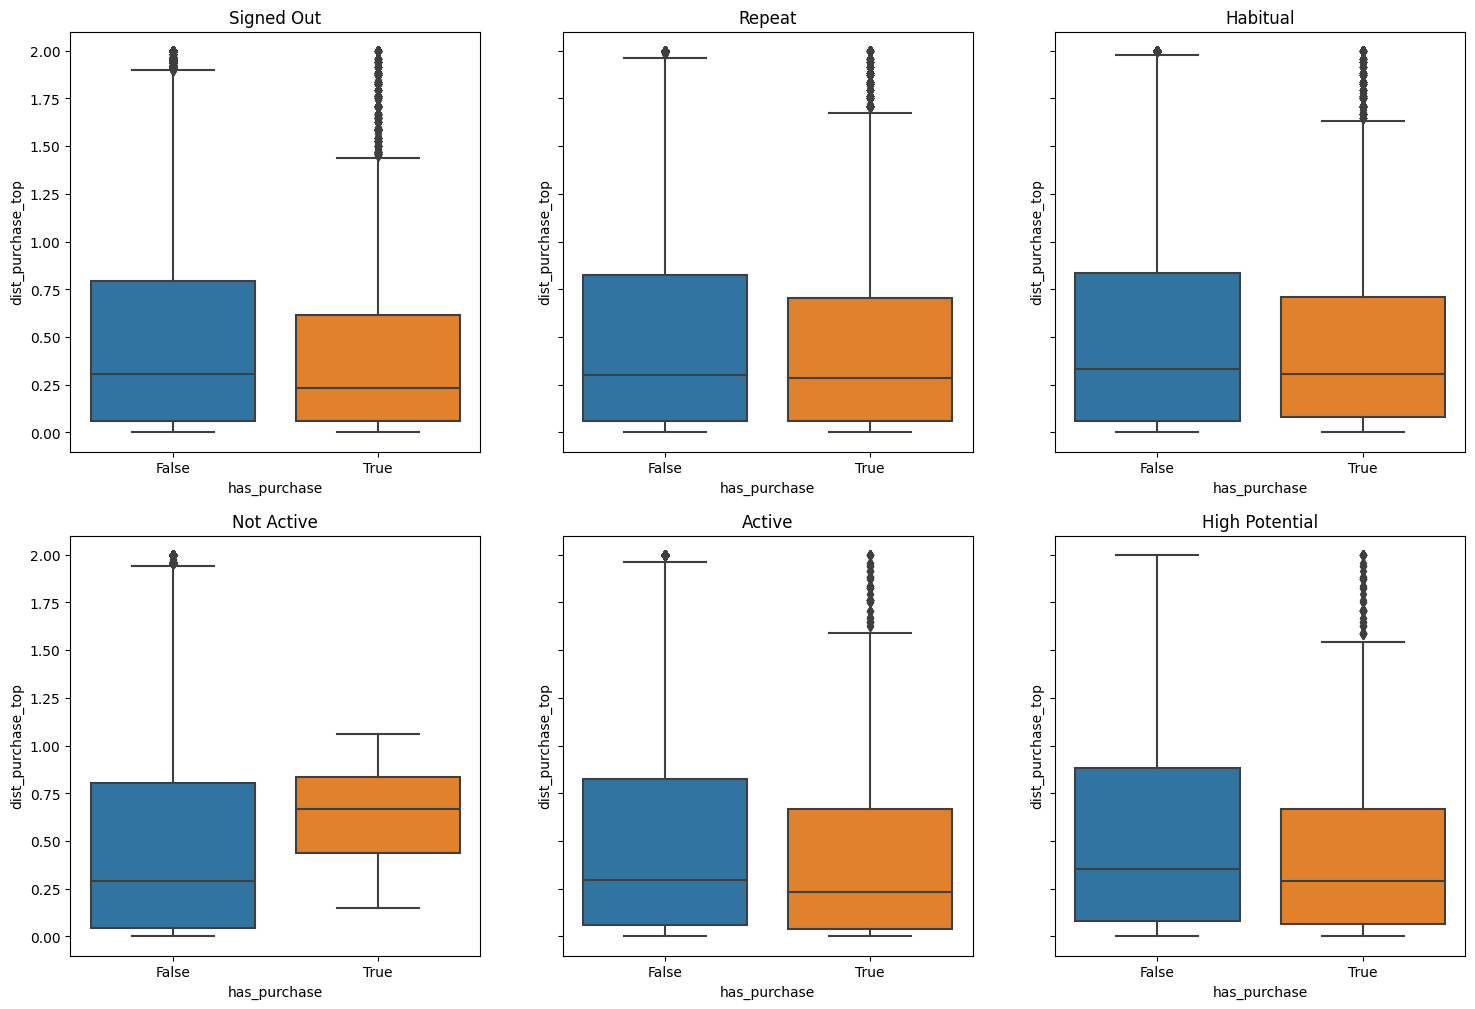

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

sns.boxplot(x=df_signout.has_purchase, y=df_signout.dist_purchase_top, ax=axes[0, 0])
axes[0, 0].set_title("Signed Out")

sns.boxplot(x=df_repeat.has_purchase, y=df_repeat.dist_purchase_top, ax=axes[0, 1])
axes[0, 1].set_title("Repeat")

sns.boxplot(x=df_habitual.has_purchase, y=df_habitual.dist_purchase_top, ax=axes[0, 2])
axes[0, 2].set_title("Habitual")

sns.boxplot(x=df_na.has_purchase, y=df_na.dist_purchase_top, ax=axes[1, 0])
axes[1, 0].set_title("Not Active")

sns.boxplot(x=df_a.has_purchase, y=df_a.dist_purchase_top, ax=axes[1, 1])
axes[1, 1].set_title("Active")

sns.boxplot(x=df_highp.has_purchase, y=df_highp.dist_purchase_top, ax=axes[1, 2])
axes[1, 2].set_title("High Potential")

plt.show()

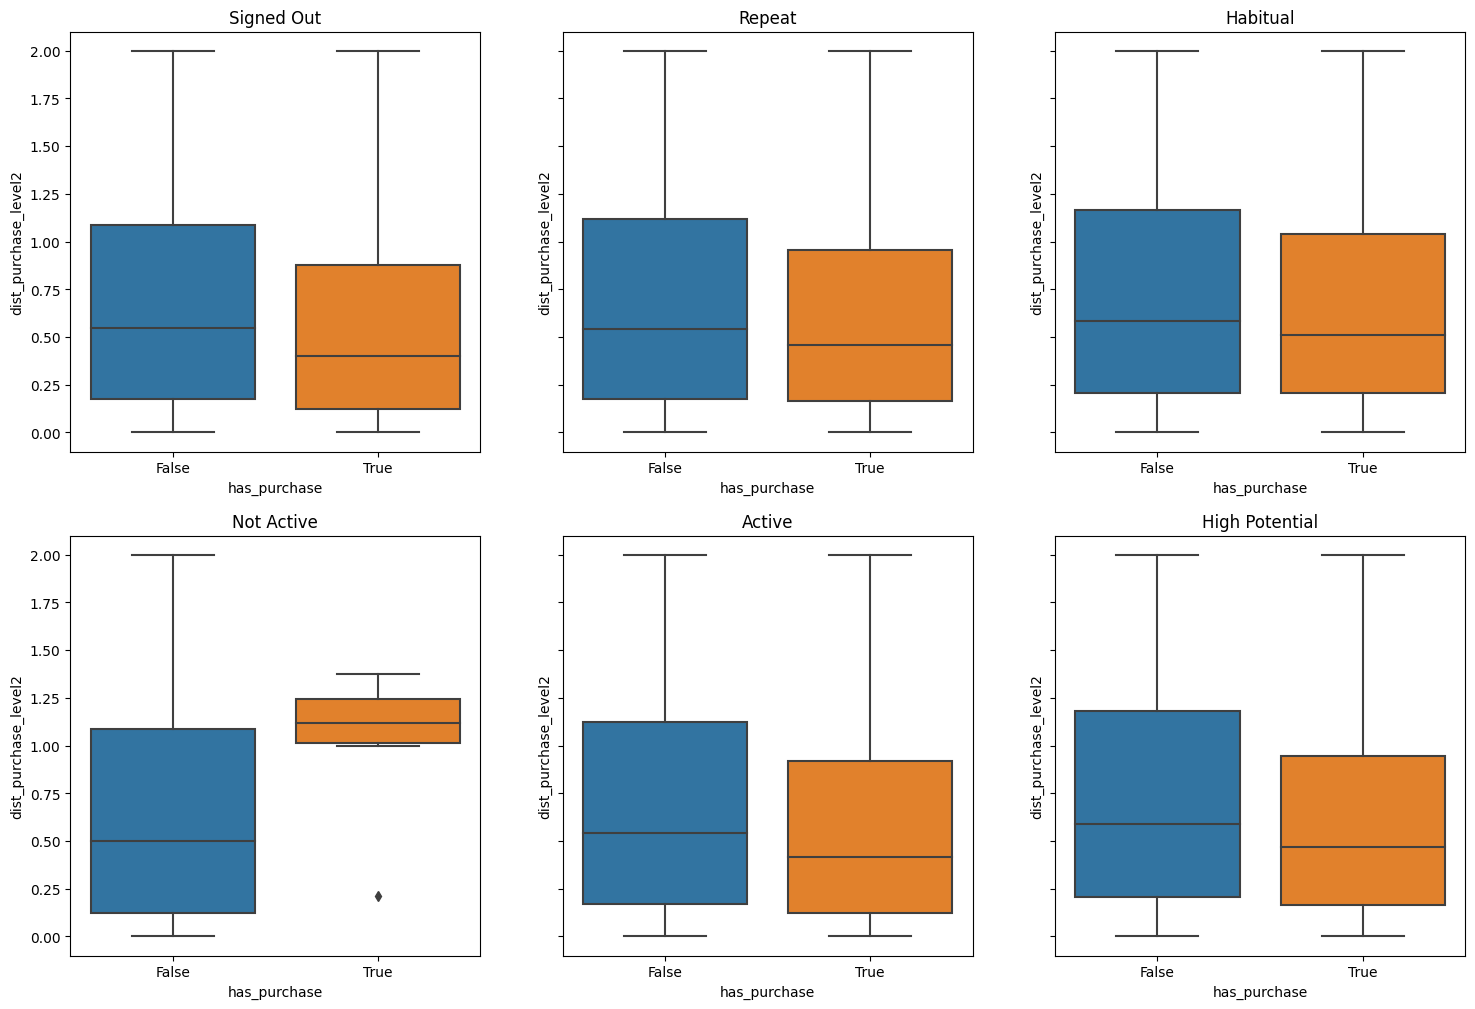

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

sns.boxplot(x=df_signout.has_purchase, y=df_signout.dist_purchase_level2, ax=axes[0, 0])
axes[0, 0].set_title("Signed Out")

sns.boxplot(x=df_repeat.has_purchase, y=df_repeat.dist_purchase_level2, ax=axes[0, 1])
axes[0, 1].set_title("Repeat")

sns.boxplot(x=df_habitual.has_purchase, y=df_habitual.dist_purchase_level2, ax=axes[0, 2])
axes[0, 2].set_title("Habitual")

sns.boxplot(x=df_na.has_purchase, y=df_na.dist_purchase_level2, ax=axes[1, 0])
axes[1, 0].set_title("Not Active")

sns.boxplot(x=df_a.has_purchase, y=df_a.dist_purchase_level2, ax=axes[1, 1])
axes[1, 1].set_title("Active")

sns.boxplot(x=df_highp.has_purchase, y=df_highp.dist_purchase_level2, ax=axes[1, 2])
axes[1, 2].set_title("High Potential")

plt.show()

In [39]:
pd.crosstab(df.has_purchase, df.buyer_segment, normalize='columns')

buyer_segment,Active,Habitual,High Potential,Not Active,Repeat,Signed Out
has_purchase,,,,,,
False,0.995893,0.991538,0.990549,0.999984,0.992174,0.996476
True,0.004107,0.008462,0.009451,0.000016,0.007826,0.003524


# By query bin

In [41]:
df.query_bin.value_counts()

top.01    3551172
head      2673283
top.1     2287273
torso      178435
tail        43700
Name: query_bin, dtype: int64

In [42]:
df_head = df[df.query_bin == "head"]
df_tail = df[df.query_bin == "tail"]
df_torso = df[df.query_bin == "torso"]
df_top1 = df[df.query_bin == "top.1"]
df_top01 = df[df.query_bin == "top.01"]

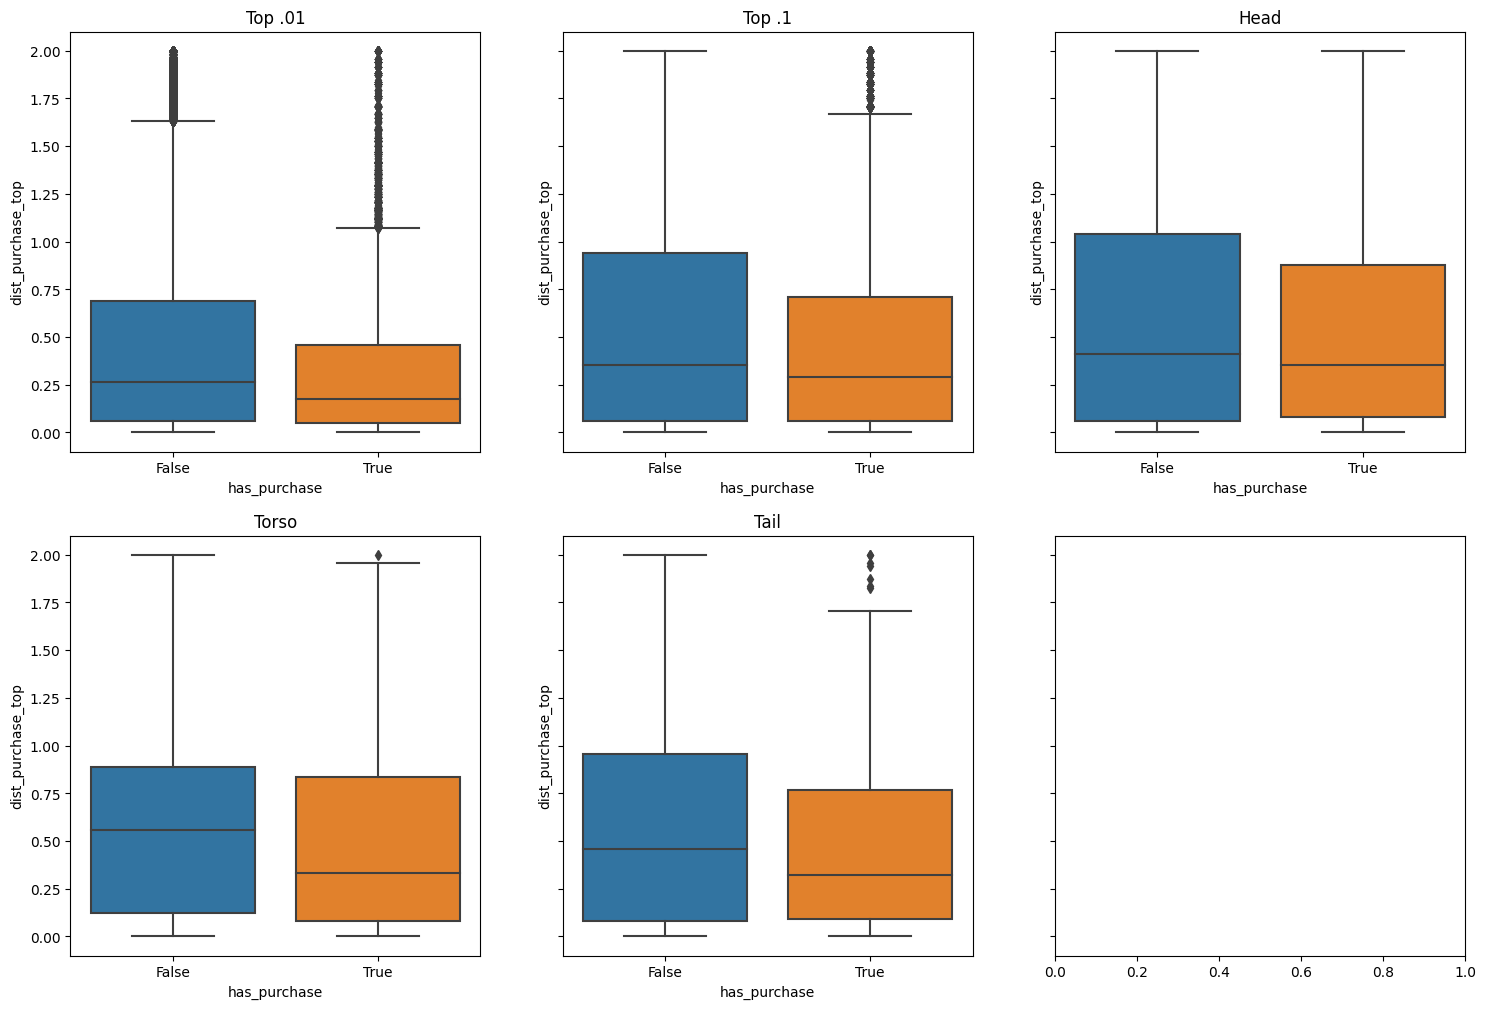

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

sns.boxplot(x=df_top01.has_purchase, y=df_top01.dist_purchase_top, ax=axes[0, 0])
axes[0, 0].set_title("Top .01")

sns.boxplot(x=df_top1.has_purchase, y=df_top1.dist_purchase_top, ax=axes[0, 1])
axes[0, 1].set_title("Top .1")

sns.boxplot(x=df_head.has_purchase, y=df_head.dist_purchase_top, ax=axes[0, 2])
axes[0, 2].set_title("Head")

sns.boxplot(x=df_torso.has_purchase, y=df_torso.dist_purchase_top, ax=axes[1, 0])
axes[1, 0].set_title("Torso")

sns.boxplot(x=df_tail.has_purchase, y=df_tail.dist_purchase_top, ax=axes[1, 1])
axes[1, 1].set_title("Tail")

plt.show()

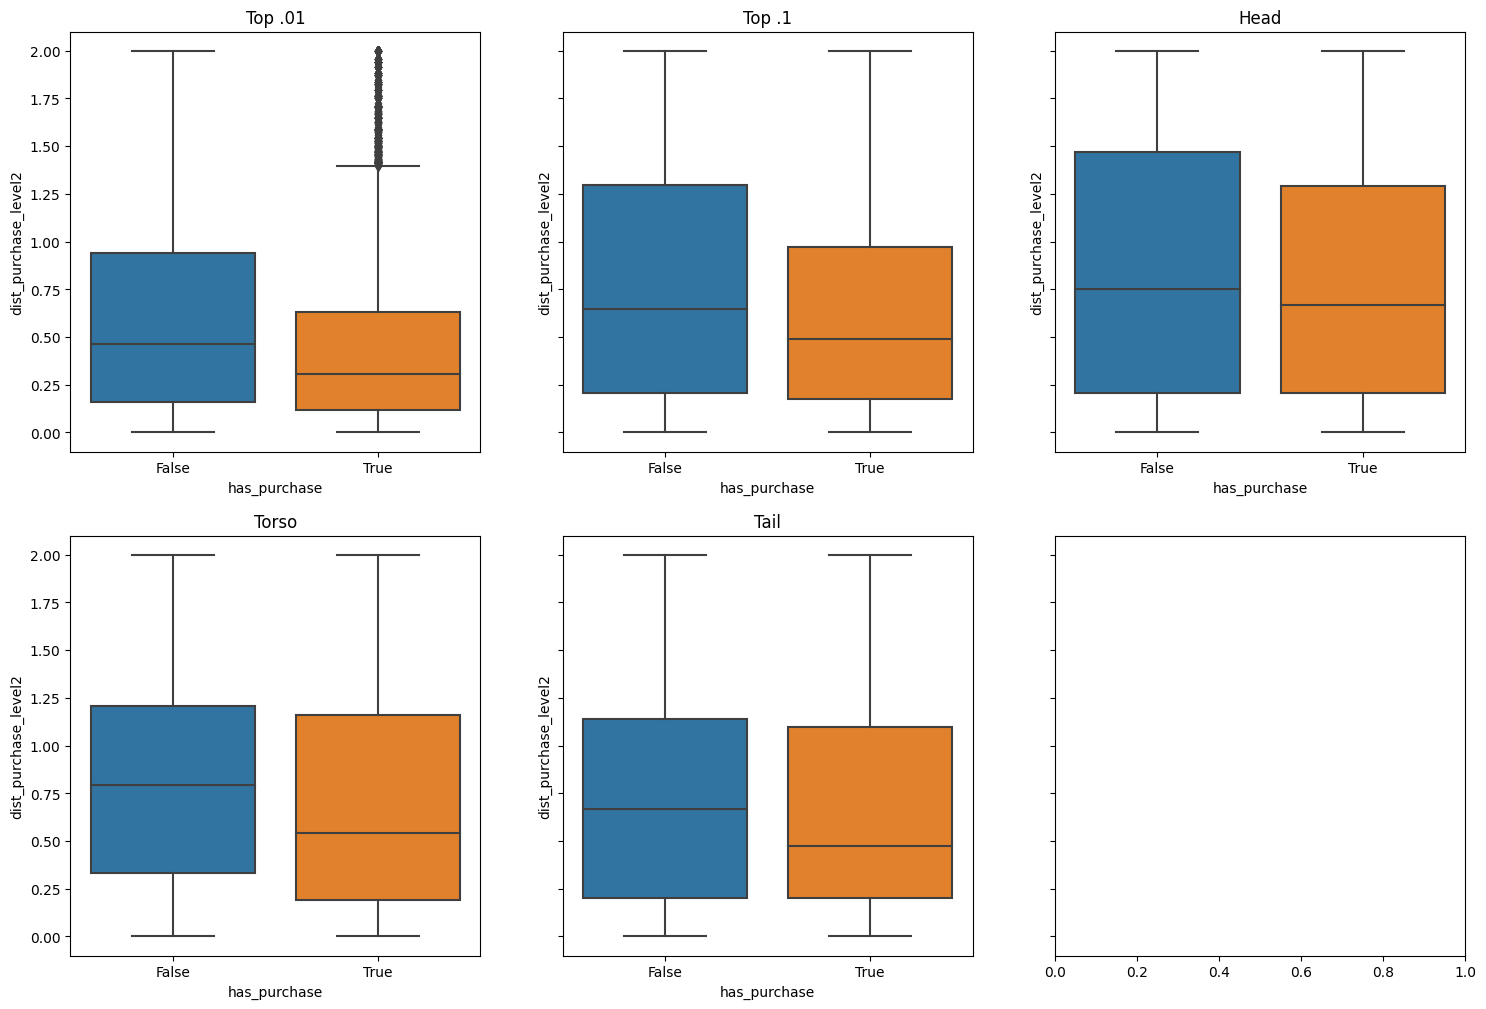

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

sns.boxplot(x=df_top01.has_purchase, y=df_top01.dist_purchase_level2, ax=axes[0, 0])
axes[0, 0].set_title("Top .01")

sns.boxplot(x=df_top1.has_purchase, y=df_top1.dist_purchase_level2, ax=axes[0, 1])
axes[0, 1].set_title("Top .1")

sns.boxplot(x=df_head.has_purchase, y=df_head.dist_purchase_level2, ax=axes[0, 2])
axes[0, 2].set_title("Head")

sns.boxplot(x=df_torso.has_purchase, y=df_torso.dist_purchase_level2, ax=axes[1, 0])
axes[1, 0].set_title("Torso")

sns.boxplot(x=df_tail.has_purchase, y=df_tail.dist_purchase_level2, ax=axes[1, 1])
axes[1, 1].set_title("Tail")

plt.show()